In [1]:
import os
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# 1) Load dataset (HF)
ds = load_dataset("fashion_mnist")
train_hf = ds["train"]
test_hf = ds["test"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

fashion_mnist/train-00000-of-00001.parqu(…):   0%|          | 0.00/30.9M [00:00<?, ?B/s]

fashion_mnist/test-00000-of-00001.parque(…):   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [48]:
train_hf[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [49]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot"
]

In [7]:
def hf_to_numpy(hf_split):
    images = []
    labels = []
    for ex in tqdm(hf_split, desc="Converting HF split"):
        arr = np.array(ex["image"], dtype=np.float32)  # (28,28)
        arr = arr / 255.0                              # normalize to [0,1]
        arr = arr.reshape(1, 28, 28)                   # (1,28,28) channel-first
        images.append(arr)
        labels.append(int(ex["label"]))
    X = np.stack(images)
    y = np.array(labels, dtype=np.int64)
    return X, y

In [8]:
X_train, y_train = hf_to_numpy(train_hf)
X_test, y_test = hf_to_numpy(test_hf)
print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Converting HF split: 100%|██████████| 10000/10000 [00:02<00:00, 4254.96it/s]


Shapes: (60000, 1, 28, 28) (60000,) (10000, 1, 28, 28) (10000,)


In [9]:
X_train.shape

(60000, 1, 28, 28)

In [10]:
y_train.shape

(60000,)

In [11]:
X_test.shape

(10000, 1, 28, 28)

In [12]:
y_test.shape

(10000,)

In [13]:
# 2) DataLoaders
BATCH_SIZE = 128
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [32]:
# 3) Model: >=2 conv blocks
class FashionCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(FashionCNN, self).__init__()
        # Block 1: Conv -> ReLU -> MaxPool
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28 -> 14
        )
        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14 -> 7
        )
        # Optional Block 3 (commented):
        # self.block3 = nn.Sequential(
        #     nn.Conv2d(64, 128, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2)
        # )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc_out = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)  # final activation (explicit as required)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.fc_out(x)
        probs = self.softmax(logits)
        return probs

In [33]:
model = FashionCNN().to(device)
print(model)

FashionCNN(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [34]:
# 4) Loss & optimizer
# Model returns softmax probabilities; use NLLLoss on log-probs for stability
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [35]:
# 5) Train loop (>=5 epochs)
EPOCHS = 5
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch} train"):
        xb = xb.to(device, dtype=torch.float)
        yb = yb.to(device, dtype=torch.long)

        optimizer.zero_grad()
        probs = model(xb)  # softmax probabilities
        log_probs = torch.log(probs + 1e-9)
        loss = criterion(log_probs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = torch.argmax(probs, dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # validation
    model.eval()
    v_loss = 0.0
    v_correct = 0
    v_total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device, dtype=torch.float)
            yb = yb.to(device, dtype=torch.long)
            probs = model(xb)
            log_probs = torch.log(probs + 1e-9)
            loss = criterion(log_probs, yb)
            v_loss += loss.item() * xb.size(0)
            preds = torch.argmax(probs, dim=1)
            v_correct += (preds == yb).sum().item()
            v_total += xb.size(0)

    val_loss = v_loss / v_total
    val_acc = v_correct / v_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch}/{EPOCHS} - Train loss: {epoch_loss:.4f}, Train acc: {epoch_acc:.4f} | Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}"
    )

Epoch 1 train: 100%|██████████| 469/469 [01:08<00:00,  6.87it/s]


Epoch 1/5 - Train loss: 0.5905, Train acc: 0.7849 | Val loss: 0.3795, Val acc: 0.8613


Epoch 2 train: 100%|██████████| 469/469 [01:07<00:00,  6.94it/s]


Epoch 2/5 - Train loss: 0.3733, Train acc: 0.8659 | Val loss: 0.3322, Val acc: 0.8782


Epoch 3 train: 100%|██████████| 469/469 [01:08<00:00,  6.86it/s]


Epoch 3/5 - Train loss: 0.3223, Train acc: 0.8841 | Val loss: 0.2907, Val acc: 0.8929


Epoch 4 train: 100%|██████████| 469/469 [01:09<00:00,  6.79it/s]


Epoch 4/5 - Train loss: 0.2900, Train acc: 0.8947 | Val loss: 0.2772, Val acc: 0.8975


Epoch 5 train: 100%|██████████| 469/469 [01:08<00:00,  6.82it/s]


Epoch 5/5 - Train loss: 0.2657, Train acc: 0.9036 | Val loss: 0.2602, Val acc: 0.9056


In [37]:
# 6) Final evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, dtype=torch.float)
        yb = yb.to(device, dtype=torch.long)
        probs = model(xb)
        preds = torch.argmax(probs, dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)

print(f"\nFinal test accuracy: {correct/total:.4f}")


Final test accuracy: 0.9056


In [38]:
# 7) Save model
out_path = "fashion_cnn_final.pth"
torch.save(model.state_dict(), out_path)
print("Saved model to", out_path)

Saved model to fashion_cnn_final.pth


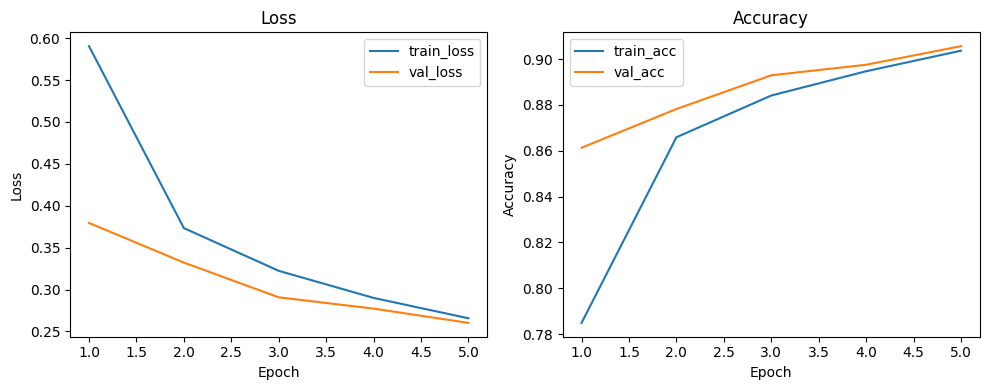

In [39]:
# 8) Plot curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label="train_loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accs, label="train_acc")
plt.plot(range(1, EPOCHS + 1), val_accs, label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.show()


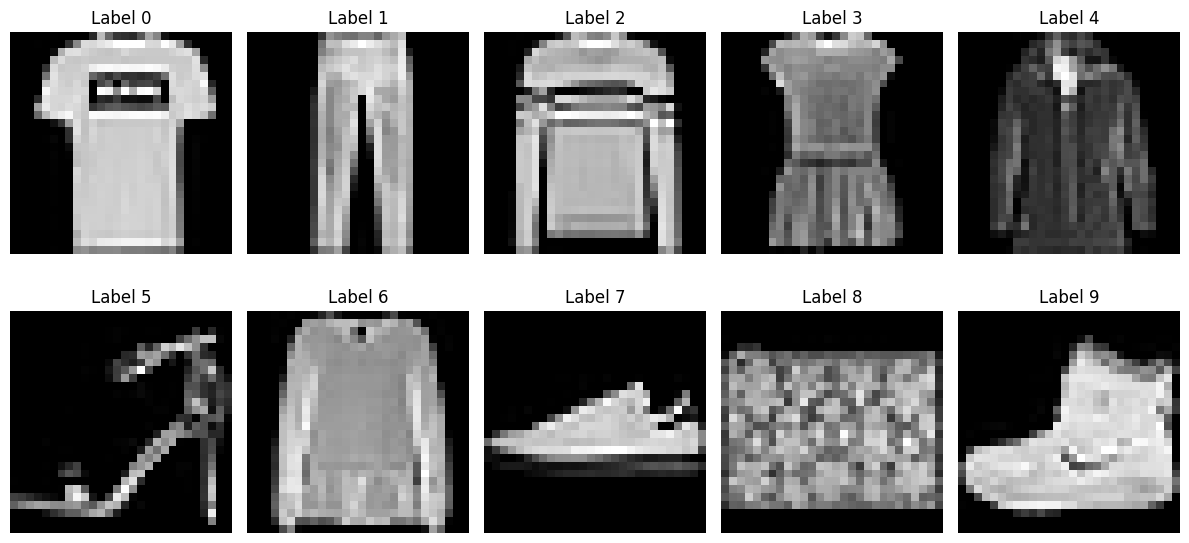

In [53]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(12, 6))

for i in range(10):
    cls = i
    # find one sample with label = i
    for idx in range(len(train_hf)):
        if train_hf[idx]["label"] == cls:
            sample = train_hf[idx]
            break

    plt.subplot(2, 5, i+1)
    plt.imshow(sample["image"], cmap="gray")
    plt.title(f"Label {cls}")
    plt.axis("off")

plt.tight_layout()
plt.show()


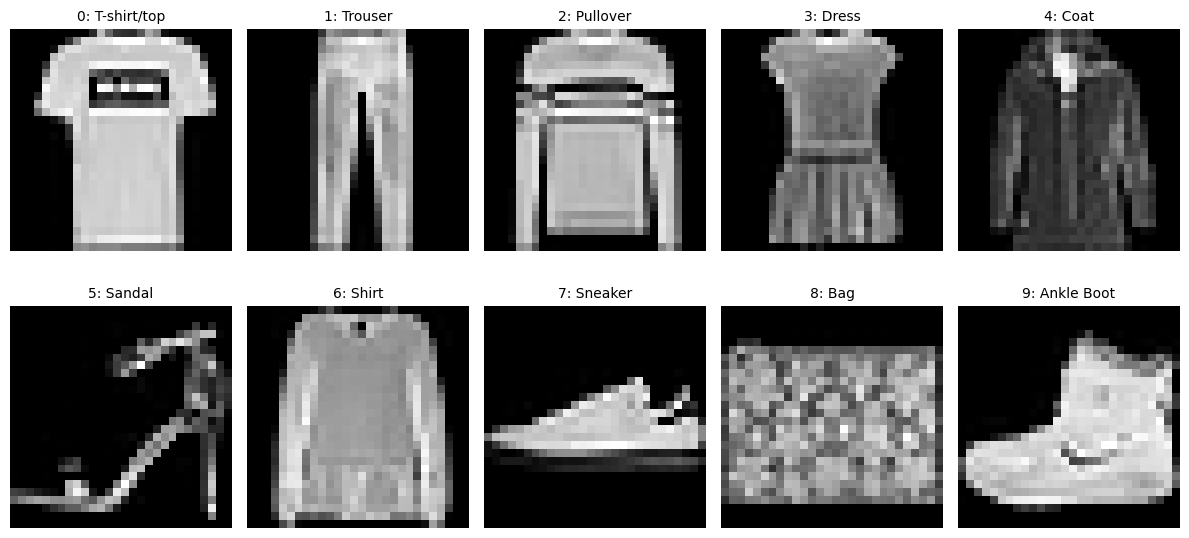

In [54]:
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(12, 6))

for i in range(10):
    cls = i
    sample = None

    # find one sample with label == cls
    for idx in range(len(train_hf)):
        if train_hf[idx]["label"] == cls:
            sample = train_hf[idx]
            break

    # fallback if not found (should not happen for Fashion-MNIST)
    if sample is None:
        print(f"No example found for class {cls} ({classes[cls]})")
        continue

    plt.subplot(2, 5, i + 1)
    # sample["image"] is a PIL Image; matplotlib can display it directly
    plt.imshow(sample["image"], cmap="gray")
    plt.title(f"{cls}: {classes[cls]}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [56]:
import torch
import numpy as np

def predict_image(img_array):
    """
    img_array: numpy array shape (1,28,28)
    """
    model.eval()

    # convert to tensor and add batch dimension -> (1, 1, 28, 28)
    x = torch.from_numpy(img_array).unsqueeze(0).to(device, dtype=torch.float)

    with torch.no_grad():
        out = model(x)

        # if model returns logits, apply softmax
        if out.shape[1] == 10 and (out.sum(dim=1) != 1.0).any():
            probs = torch.softmax(out, dim=1)
        else:
            probs = out

        predicted_idx = torch.argmax(probs, dim=1).item()

    return classes[predicted_idx]


In [47]:
print(predict_image(X_test[0]))
print(predict_image(X_test[1]))
print(predict_image(X_test[2]))

Ankle Boot
Pullover
Trouser


In [50]:
import matplotlib.pyplot as plt
import torch

def show_prediction_with_actual(idx):
    """
    idx: index of the test image you want to check
    """
    img_array = X_test[idx]  # (1,28,28)
    true_idx = int(y_test[idx])  # actual label (0–9)
    true_name = classes[true_idx]

    # ---- prediction ----
    model.eval()
    x = torch.from_numpy(img_array).unsqueeze(0).to(device, dtype=torch.float)

    with torch.no_grad():
        out = model(x)
        if out.shape[1] == 10 and (out.sum(dim=1) != 1.0).any():
            probs = torch.softmax(out, dim=1)
        else:
            probs = out
        pred_idx = torch.argmax(probs, dim=1).item()
        pred_name = classes[pred_idx]

    # ---- show image ----
    plt.imshow(img_array.reshape(28,28), cmap='gray')
    plt.title(f"Actual: {true_name}\nPredicted: {pred_name}")
    plt.axis("off")
    plt.show()

    return true_name, pred_name


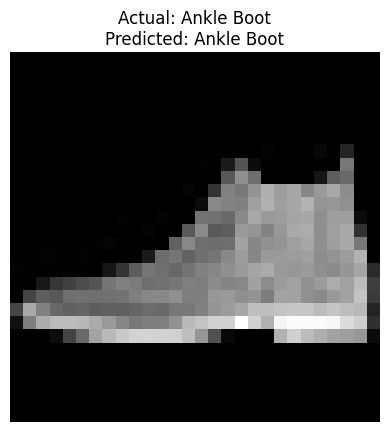

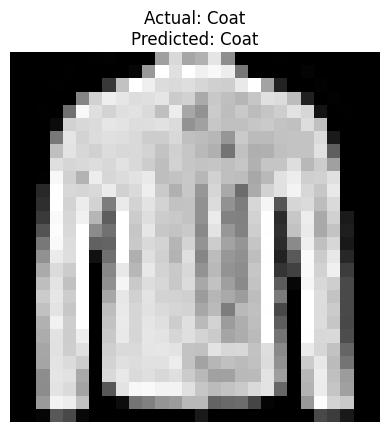

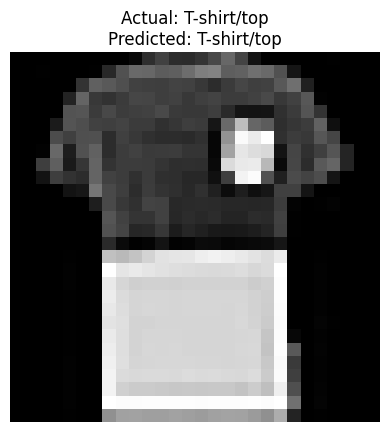

('T-shirt/top', 'T-shirt/top')

In [51]:
show_prediction_with_actual(0)
show_prediction_with_actual(50)
show_prediction_with_actual(120)

**For this project, I applied the FACTUAL branch of the conditional logic because image classification produces a single, objective label for each input image. After the CNN predicts the class with the highest probability, the system retrieves one representative example (Top-1 chunk) from the training set that has the same label to help verify the prediction visually. This provides a concise, factual answer that includes both the predicted class and an exemplar image for comparison. The ANALYTICAL logic path (Top-5 retrieval and step-by-step reasoning) is not used, because the task does not require multi-step reasoning—only accurate identification of the correct category based on the model’s learned features.**